# Notebook for developing code to simulate the SiPM pulses

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal

np.random.seed(0)

In [246]:
# class Particle:
#     """ """
#     def __init__(self, type: str = 'MIP', pos: np.array = np.zeros(4), velocity: np.array = np.zeros(3)):
#         self.type     = type
#         self.pos      = pos
#         self.velocity = velocity
#         self.energy   = None
    
    
#     def __repr__(self):
#         return "<Particle type: %s, pos: %s, velocity: %s, energy: %s>" % (self.type, self.pos, self.velocity, self.energy)
    
#     def get_type(self):
#         return self.type
    
#     def get_pos(self):
#         return self.pos
# class MIP(Particle):
    
    
# class Photon(Particle):
    

In [247]:
np.random.uniform(0.1e-6, 0.9e-6)

6.704441920416511e-07

In [299]:
class ParticleGun:
    
    def __init__(self, ptype: int = 0):
        self.ptype = ptype
        self.t_dist = lambda n = 1: np.random.uniform(0.25e-6, 0.75e-6) if n is 1 else np.random.uniform(0.25e-6, 0.75e-6, n)
        
    def generate(self, n: int = 1) -> np.ndarray:
        """ 
        Generates a new particle represented by a numpy.ndarray of length 10:
            [0]: particle_idx
            [1]: mother_idx
            [2]: Particle type, 0 = MIP, 10 = scintillation photon
            [3]: x
            [4]: y
            [5]: z
            [6]: t
            [7]: v_x
            [8]: v_y
            [9]: v_z
        """
        particles = np.zeros((n,10))
        particles[:,0] += np.arange(n)
        particles[:,6] += self.t_dist(n)

        return particles

In [300]:
class Scintillator():
    
    def __init__(self):

#         self.t_dist = lambda : np.random.normal(5e-9, 1e-9)
        self.t_dist = lambda : 1e-9
        self.n_dist = lambda : 1
            
    def generate(self, primaries: np.ndarray)-> np.ndarray:
        
        idx = max(primaries[:,0])
        
        photons = np.zeros((0,10))
        
        for primary in primaries:
            n_daughters = self.n_dist()
            for _ in range(n_daughters):
                idx += 1
                photon = np.zeros(10)
                photon[0] = idx
                photon[1] = primary[0]
                photon[6] = primary[6] + self.t_dist()
                photons = np.vstack([photons,photon])
        
        return photons
        

In [301]:
t_dist = lambda n = 1: np.random.uniform(0, 10e-9) if n is 1 else np.random.uniform(0, 10e-9, n)
t_dist(2)

array([7.63960965e-09, 8.10692611e-09])

In [302]:
length    = 10  # 1 micro second waveforms 
sampling  = 1e-3 # aka 10 ps

length/sampling

10000.0

In [303]:
class WaveformGenerator():
    
    def __init__(self, length: np.double = 1e-6, precision: np.double = 10e-12):
        self.length    = length  # 1 micro second waveforms 
        self.precision  = precision # aka 10 ps 
    
    def generate(self):
        
        n_samples = int(self.length/self.precision)
        
        return np.zeros(n_samples)

In [304]:
class SiPM():
    
    def __init__(self, precision: np.double = 10e-12 ):
        self.qe                   = 1.0
        self.dist_delay           = lambda : 0.5e-9
        self.precision            = precision
#         self.pulse_length         = 250e-8
        self.pulse_length = int(250e-9/self.precision)
        
    def generate(self, waveform: np.ndarray, photons: np.ndarray)-> np.ndarray:
        
        for photon in photons:
            if np.random.uniform() < self.qe:
                t = photon[6] + self.dist_delay()
                t_idx = int(t/self.precision)
                pulse = self.generate_pulse()
                waveform[t_idx:t_idx + pulse.shape[0]] += pulse
                
        return waveform

    def generate_pulse(self)-> np.ndarray:
        pulse = signal.unit_impulse(self.pulse_length, 0)
#         pulse = np.zeros(int(self.pulse_length/self.sampling))
        
        return pulse


In [305]:
# def test(arr: np.ndarray):
#     arr[0:4] += 5
#     return arr

# arr = np.zeros(10)

# test(arr)

arr = np.zeros(10)
arr[1:4] += np.ones(3) 
arr.shape[0]

10

In [306]:
class Electronics():
    
    def __init__(self):

        self.amp        = 8.9
        self.pedestal   = 0.5 

    def generate(self, sipm_wf: np.ndarray)-> np.ndarray:
        
        # Amplifier
        sipm_wf *= self.amp
        
        # Add noise: mean, standard deviation and number of samples
        mu, sigma, n = 0, 0.25, sipm_wf.shape[0] # 
        sipm_wf     += np.random.normal(mu, sigma, n)
        
        return sipm_wf

In [307]:
class Digitizer():
    
    def __init__(self, precision: np.double = 10e-12,
                 sampling: np.double        = 0.8e-9,
                 res: np.double             = 2**8,
                 vert_range: np.double      = 0.1 ):
        
        self.precision = precision
        self.sampling = sampling
        self.res = res
        self.vert_range = vert_range
        
    def generate(self, electronics_wf: np.ndarray)-> np.ndarray:
        
        
        digitzed_wf = np.zeros()
        
        return electronics_wf

In [308]:
class Event():

    def __init__(self, idx: int = -1):
        
        self.evt_idx      = idx
        self.primaries    = []
        self.photons      = []
        self.wf           = None
        self.sipm_wf      = None
        self.elec_wf      = None
        self.digitized_wf = None
        
        columns = ['primaries_file',
                   'scintillation_photons_file',
                   'digitized_wf_file',
                   'n_particles',
                   'n_photons']
        
        data    = [str(self.evt_idx).zfill(7) + '_primaries.csv',
                   str(self.evt_idx).zfill(7) + '_scintillation_photons.csv',
                   str(self.evt_idx).zfill(7) + '_digitzed_wf.csv',
                   np.nan,
                   np.nan]
        
        self.meta    = pd.Series(data, index = columns) 
    
    def get_meta(self):
        return self.meta
    
    def set_primaries(self, primaries):
        self.primaries = primaries
    
    def get_primaries(self):
        return self.primaries
    
    def set_photons(self, photons):
        self.photons = photons
    
    def get_photons(self):
        return self.photons
    
    def set_wf(self, wf):
        self.wf = wf
    
    def get_wf(self):
        return self.wf
    
    def set_sipm_wf(self, sipm_wf):
        self.sipm_wf = sipm_wf
    
    def get_sipm_wf(self):
        return self.sipm_wf
    
    def set_elec_wf(self, elec_wf):
        self.elec_wf = elec_wf
    
    def get_elec_wf(self):
        return self.elec_wf
    
    def set_digitized_wf(self, digitized_wf):
        self.digitized_wf = digitized_wf
    
    def get_digitized_wf(self):
        return self.digitized_wf

    def save_event(self, root_dir: str):
        """ Save primary particles and scintillation photons in separate files."""
        
        columns = ['particle_idx',
                   'mother_idx',
                   'type',
                   'x',
                   'y',
                   'z',
                   't',
                   'v_x',
                   'v_y',
                   'v_z']
        
        # Store the primary particles
        primaries_df = pd.DataFrame(columns = columns)
        
        for primary in self.primaries:
            se = pd.Series(primary, index = columns)
            primaries_df = primaries_df.append(se, ignore_index=True)

        primaries_df.to_csv(os.path.join(root_dir, self.meta['primaries_file']))
        
        # Store the scintillation photons
        photons_df = pd.DataFrame(columns = columns)
        
        for photon in self.photons:
            se = pd.Series(photon, index = columns)
            photons_df = photons_df.append(se, ignore_index=True)

        photons_df.to_csv(os.path.join(root_dir, self.meta['scintillation_photons_file']))
        
        # Store the waveforms
        
        
        

In [309]:
class SimulationHandler:
    
    def __init__(self):
        
        self.idx          = -1
        self.primary_gun  = ParticleGun(ptype=0)
        self.scintillator = Scintillator()
        self.wf_generator = WaveformGenerator()
        self.sipm         = SiPM()
        self.electronics  = Electronics()
        self.digitizer    = Digitizer()
        
        self.events = []
        
        columns = ['primaries_file',
                   'scintillation_photons_file',
                   'digitized_wf_file',
                   'n_particles',
                   'n_photons']
        
        self.events_df = pd.DataFrame(columns = columns)
    
    def simulate_event(self):
        
        self.idx      += 1
        event          = Event(self.idx)
        
        primaries      = self.primary_gun.generate(n=1)
        event.set_primaries(primaries)
        
        photons        = self.scintillator.generate(primaries)
        event.set_photons(photons)
        
        wf             = self.wf_generator.generate()
        sipm_wf        = self.sipm.generate(wf, photons)
        electronics_wf = self.electronics.generate(sipm_wf)
        digitized_wf   = self.digitizer.generate(electronics_wf)
        event.set_digitized_wf(digitized_wf)
        
        self.events.append(event)
        
        return electronics_wf

        
#     def simulate_and_save_event(self):
    """ TODO IMPLEMENT"""
    
    
    def save_events(self, root_dir):
        
        for event in self.events:
            
            meta = event.get_meta()
            
            # save particle_file
            # save photon_file
            # save waveform_file
            self.events_df = self.events_df.append(meta, ignore_index=True)
            event.save_event(root_dir)
            
        self.events_df.to_csv(os.path.join(root_dir,'test.csv'))
             

In [310]:
handler = SimulationHandler()

handler.simulate_event()
# handler.simulate_event()

# handler.events[1].primaries
handler.save_events(r'C:\Users\Miroslav Gabriel\Workspace\claws-neural-net-discriminator\data\test')

In [311]:
import matplotlib.pyplot as plt

handler = SimulationHandler()

wf = handler.simulate_event()

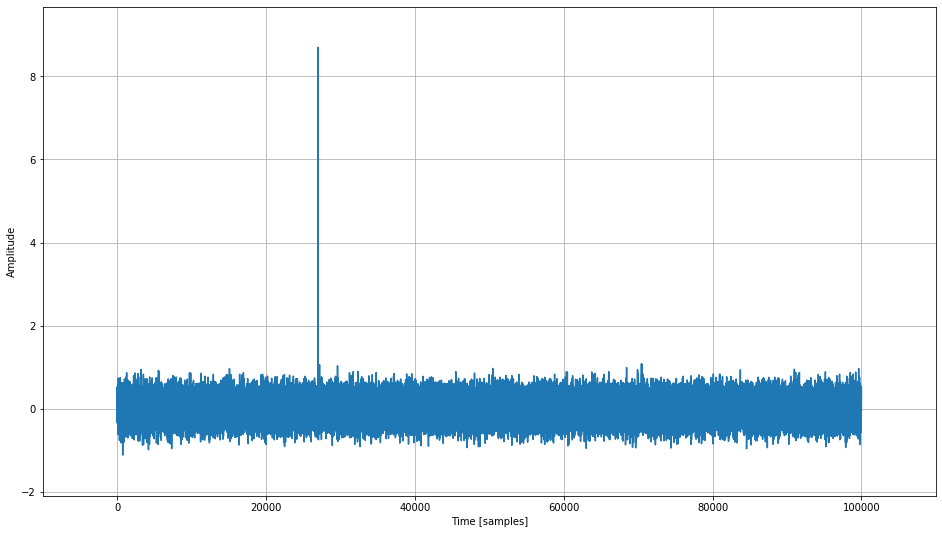

In [312]:
plt.figure(figsize=(16, 9))

plt.plot(np.arange(0, len(wf)), wf )

plt.margins(0.1, 0.1)
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
# plt.xlim(3.23e4, 3.26e4)
plt.show()